In [18]:
# Import necessary libraries
import h5py
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from tqdm import tqdm
import torch
from torch.utils.data import Dataset
import h5py
import torch.nn as nn
import numpy as np

import torch
from torch.utils.data import Dataset
import h5py
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader

import h5py
import torch
from torch.utils.data import Dataset

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [2]:
input_filename = '/mnt/f/hprc/segments.hdf5'
train_dataset_label = "train"
val_dataset_label = "val"
test_dataset_label = "test"

In [3]:
class DNADataset(Dataset):
    def __init__(self, hdf5_filename, split, chunk_size=512, overlap=0, mask_prob=0.15):
        self.hdf5_filename = hdf5_filename
        self.split = split
        self.chunk_size = chunk_size
        self.overlap = overlap
        self.mask_prob = mask_prob
        
        self.nucleotide_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
        self.vocab_size = 6  # 4 nucleotides + 1 [MASK] token + 1 padding index
        self.padding_index = self.vocab_size - 1
        self.mask_token_index = self.vocab_size - 2
        
        self.hdf5_file = None
        self.sequences = None
        self.chunks = None

    def _open_hdf5(self):
        if self.hdf5_file is None:
            self.hdf5_file = h5py.File(self.hdf5_filename, "r")
            self.sequences = self.hdf5_file[self.split]
            self.chunks = self._create_chunks()

    def _create_chunks(self):
        chunks = []
        for idx, seq in enumerate(self.sequences):
            seq_len = len(seq)
            if seq_len == 0:
                continue
            if seq_len <= self.chunk_size:
                chunks.append((idx, 0, seq_len))
            else:
                step = self.chunk_size - self.overlap
                for start in range(0, seq_len - self.chunk_size + 1, step):
                    end = start + self.chunk_size
                    chunks.append((idx, start, end))
                # handling the last chunk if it doesn't fit exactly
                if (seq_len - self.chunk_size) % step != 0:
                    start = seq_len - self.chunk_size
                    end = seq_len
                    chunks.append((idx, start, end))
        return chunks

    def __len__(self):
        if self.chunks is None:
            self._open_hdf5()
        return len(self.chunks)

    def __getitem__(self, idx):
        if self.hdf5_file is None:
            self._open_hdf5()

        seq_idx, start, end = self.chunks[idx]
        seq = self.sequences[seq_idx][start:end]

        # Shape: (seq_len,)
        seq_tensor = torch.from_numpy(seq).long()

        input_seq, labels = self._apply_masking(seq_tensor)

        # Shape: seq_len, vocab_size
        one_hot_input_seq = torch.nn.functional.one_hot(input_seq, num_classes=self.vocab_size).float()

        return one_hot_input_seq, labels

    def _apply_masking(self, seq_tensor):
        seq_len = seq_tensor.size(0)
        labels = seq_tensor.clone()

        # Create mask by deciding which positions to mask
        mask = torch.rand(seq_len) < self.mask_prob
        # This will result in computing loss on masked positions only
        labels[~mask] = -100

        # Replace masked positions with [MASK] token index
        input_seq = seq_tensor.clone()
        input_seq[mask] = self.mask_token_index

        return input_seq, labels

    def __del__(self):
        if self.hdf5_file is not None:
            self.hdf5_file.close()
            self.hdf5_file = None


In [4]:
def collate_fn(batch):
    inputs = [item[0] for item in batch]  # item[0].shape: (seq_len, vocab_size)
    labels = [item[1] for item in batch]  # item[1].shape: (seq_len,)

    seq_lengths = [input_seq.size(0) for input_seq in inputs]
    max_length = max(seq_lengths)
    batch_size = len(inputs)
    vocab_size = inputs[0].size(1)

    padded_inputs = torch.zeros(batch_size, max_length, vocab_size)
    padded_labels = torch.full((batch_size, max_length), fill_value=-100, dtype=torch.long)

    for i in range(batch_size):
        seq_len = inputs[i].size(0)
        padded_inputs[i, :seq_len, :] = inputs[i]
        padded_labels[i, :seq_len] = labels[i]

    return padded_inputs, padded_labels


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=10000):
        super(PositionalEncoding, self).__init__()

        # positional encoding
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        # -np.log(10000.0) is part of the sinusoidal positional encoding
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        if d_model % 2 == 1:
            pe[:, 1::2] = torch.cos(position * div_term[:-1])
        else:
            pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)  # shape: (1, max_len, d_model)
        self.register_buffer("pe", pe)

    def forward(self, x):
        # x shape: (batch_size, seq_len, d_model)
        seq_len = x.size(1)
        x = x + self.pe[:, :seq_len, :]
        return x


In [6]:
class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, dim_feedforward, dropout=0.1, max_len=10000):
        super(TransformerModel, self).__init__()
        self.input_linear = nn.Linear(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_len=max_len)
        encoder_layer = nn.TransformerEncoderLayer(d_model, num_heads, dim_feedforward, dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_layer = nn.Linear(d_model, vocab_size - 2)  # Exclude [MASK] token and padding index
        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_key_padding_mask=None):
        # src: (batch_size, seq_len, vocab_size)
        x = self.input_linear(src)  # Shape: (batch_size, seq_len, d_model)
        x = self.positional_encoding(x)
        x = x.transpose(0, 1)  # Transformer expects input as (seq_len, batch_size, d_model)
        x = self.transformer_encoder(x, src_key_padding_mask=src_key_padding_mask)
        x = x.transpose(0, 1)  # Back to (batch_size, seq_len, d_model)
        output = self.output_layer(x)  # Shape: (batch_size, seq_len, vocab_size - 1)
        return output

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
chunk_size = 512
train_dataset = DNADataset(hdf5_filename=input_filename, split=train_dataset_label, chunk_size=chunk_size, overlap=0)
val_dataset = DNADataset(hdf5_filename=input_filename, split=val_dataset_label, chunk_size=chunk_size, overlap=0)

In [9]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [10]:
vocab_size = train_dataset.vocab_size
d_model = 128
num_heads = 8
num_layers = 4
dim_feedforward = 512
dropout = 0.1
learning_rate = 1e-4

In [11]:
model = TransformerModel(
    vocab_size=vocab_size, 
    d_model=d_model, 
    num_heads=num_heads,
    num_layers=num_layers, 
    dim_feedforward=dim_feedforward, 
    dropout=dropout,
    max_len=chunk_size)

model.to(device)

criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

/home/hamed/hprc_graph_embedding/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [12]:
num_epochs = 30

train_losses = []
val_losses = []

In [13]:
for epoch in range(num_epochs):
    model.train()
    total_train_loss = 0
    for batch_inputs, batch_labels in tqdm(train_loader):
        batch_inputs = batch_inputs.to(device)  # Shape: (batch_size, seq_len, vocab_size)
        batch_labels = batch_labels.to(device)  # Shape: (batch_size, seq_len)

        optimizer.zero_grad()

        # Create src_key_padding_mask: True for padding positions
        src_key_padding_mask = torch.all(batch_inputs == 0, dim=-1)  # Shape: (batch_size, seq_len)

        outputs = model(batch_inputs, src_key_padding_mask=src_key_padding_mask)  # Shape: (batch_size, seq_len, vocab_size - 1)

        # Adjust labels: map padding index to -100
        adjusted_labels = batch_labels.clone()
        adjusted_labels[adjusted_labels == train_dataset.padding_index] = -100  # Ignore padding positions

        # Remove [MASK] token index from labels (if present)
        adjusted_labels[adjusted_labels == train_dataset.mask_token_index] = -100  # Ignore masked positions in loss

        # Ensure labels are within [0, vocab_size - 3] (since vocab_size - 1 is padding index, and vocab_size - 2 is [MASK] token)
        valid_label_mask = (adjusted_labels >= 0) & (adjusted_labels <= 3)
        adjusted_labels[~valid_label_mask] = -100  # Ignore any invalid labels

        # Compute loss
        loss = criterion(outputs.view(-1, vocab_size - 2), adjusted_labels.view(-1))

        if not torch.isfinite(loss):
            print("Loss is NaN or Inf, skipping batch")
            continue

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation
    model.eval()
    total_val_loss = 0
    with torch.no_grad():
        for batch_inputs, batch_labels in tqdm(val_loader):
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            src_key_padding_mask = torch.all(batch_inputs == 0, dim=-1)

            outputs = model(batch_inputs, src_key_padding_mask=src_key_padding_mask)

            adjusted_labels = batch_labels.clone()
            adjusted_labels[adjusted_labels == train_dataset.padding_index] = -100
            adjusted_labels[adjusted_labels == train_dataset.mask_token_index] = -100 # train_dataset.unknown_nucleotide_index

            loss = criterion(outputs.view(-1, vocab_size - 2), adjusted_labels.view(-1))

            total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(val_loader)
    val_losses.append(avg_val_loss)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}")


100%|██████████| 181/181 [00:01<00:00, 163.21it/s]


Epoch 1/30, Train Loss: 1.3281, Validation Loss: 1.3553


100%|██████████| 181/181 [00:01<00:00, 159.37it/s]


Epoch 2/30, Train Loss: 1.3253, Validation Loss: 1.3505


100%|██████████| 181/181 [00:01<00:00, 164.73it/s]


Epoch 3/30, Train Loss: 1.3222, Validation Loss: 1.3497


100%|██████████| 181/181 [00:01<00:00, 161.48it/s]


Epoch 4/30, Train Loss: 1.3045, Validation Loss: 1.3090


100%|██████████| 181/181 [00:01<00:00, 165.86it/s]


Epoch 5/30, Train Loss: 1.0066, Validation Loss: 1.1328


100%|██████████| 181/181 [00:01<00:00, 165.65it/s]


Epoch 6/30, Train Loss: 0.7936, Validation Loss: 1.0922


100%|██████████| 181/181 [00:01<00:00, 163.70it/s]


Epoch 7/30, Train Loss: 0.6866, Validation Loss: 1.0582


100%|██████████| 181/181 [00:01<00:00, 166.90it/s]


Epoch 8/30, Train Loss: 0.5996, Validation Loss: 1.0234


100%|██████████| 181/181 [00:01<00:00, 162.61it/s]


Epoch 9/30, Train Loss: 0.5229, Validation Loss: 0.9843


100%|██████████| 181/181 [00:01<00:00, 162.86it/s]


Epoch 10/30, Train Loss: 0.4461, Validation Loss: 0.9597


100%|██████████| 181/181 [00:03<00:00, 45.83it/s] 


Epoch 11/30, Train Loss: 0.3697, Validation Loss: 0.9286


100%|██████████| 181/181 [00:01<00:00, 163.71it/s]


Epoch 12/30, Train Loss: 0.3038, Validation Loss: 0.9108


100%|██████████| 181/181 [00:01<00:00, 158.00it/s]


Epoch 13/30, Train Loss: 0.2544, Validation Loss: 0.9124


100%|██████████| 181/181 [00:01<00:00, 168.93it/s]


Epoch 14/30, Train Loss: 0.2227, Validation Loss: 0.8862


100%|██████████| 181/181 [00:01<00:00, 156.49it/s]


Epoch 15/30, Train Loss: 0.1995, Validation Loss: 0.8880


100%|██████████| 181/181 [00:01<00:00, 142.13it/s]


Epoch 16/30, Train Loss: 0.1841, Validation Loss: 0.8820


100%|██████████| 181/181 [00:01<00:00, 158.59it/s]


Epoch 17/30, Train Loss: 0.1727, Validation Loss: 0.8707


100%|██████████| 181/181 [00:01<00:00, 169.65it/s]


Epoch 18/30, Train Loss: 0.1633, Validation Loss: 0.8743


100%|██████████| 181/181 [00:01<00:00, 156.44it/s]


Epoch 19/30, Train Loss: 0.1559, Validation Loss: 0.8571


100%|██████████| 181/181 [00:01<00:00, 170.83it/s]


Epoch 20/30, Train Loss: 0.1510, Validation Loss: 0.8599


100%|██████████| 181/181 [00:01<00:00, 169.64it/s]


Epoch 21/30, Train Loss: 0.1458, Validation Loss: 0.8672


100%|██████████| 181/181 [00:01<00:00, 161.62it/s]


Epoch 22/30, Train Loss: 0.1413, Validation Loss: 0.8483


100%|██████████| 181/181 [00:01<00:00, 169.30it/s]


Epoch 23/30, Train Loss: 0.1381, Validation Loss: 0.8448


100%|██████████| 181/181 [00:01<00:00, 163.62it/s]


Epoch 24/30, Train Loss: 0.1349, Validation Loss: 0.8286


100%|██████████| 181/181 [00:01<00:00, 156.30it/s]


Epoch 25/30, Train Loss: 0.1322, Validation Loss: 0.8291


100%|██████████| 181/181 [00:01<00:00, 169.28it/s]


Epoch 26/30, Train Loss: 0.1308, Validation Loss: 0.8286


100%|██████████| 181/181 [00:01<00:00, 170.12it/s]


Epoch 27/30, Train Loss: 0.1267, Validation Loss: 0.8318


100%|██████████| 181/181 [00:01<00:00, 155.66it/s]


Epoch 28/30, Train Loss: 0.1251, Validation Loss: 0.8284


100%|██████████| 181/181 [00:01<00:00, 169.48it/s]


Epoch 29/30, Train Loss: 0.1236, Validation Loss: 0.8355


100%|██████████| 181/181 [00:01<00:00, 171.44it/s]

Epoch 30/30, Train Loss: 0.1209, Validation Loss: 0.8218


In [27]:
# After training is complete, save the model
torch.save(model.state_dict(), "trained_model.pth")

In [29]:
model = TransformerModel(
    vocab_size=vocab_size, 
    d_model=d_model, 
    num_heads=num_heads,
    num_layers=num_layers, 
    dim_feedforward=dim_feedforward, 
    dropout=dropout,
    max_len=chunk_size)

model.load_state_dict(torch.load("trained_model.pth"))
model.to(device)

/tmp/ipykernel_68540/1956377585.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("trained_model.pth"))


TransformerModel(
  (input_linear): Linear(in_features=6, out_features=128, bias=True)
  (positional_encoding): PositionalEncoding()
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (output_layer): Linear(in_features=128, out_features=4, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

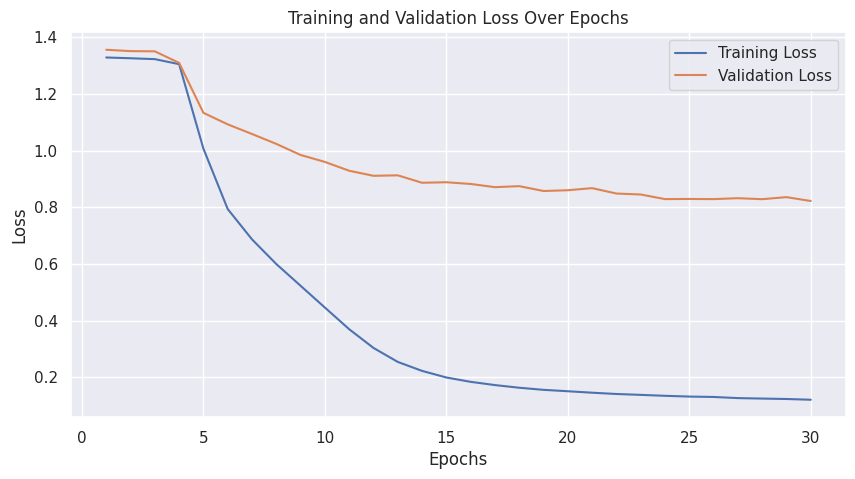

In [19]:
# Plot the losses
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [16]:
test_dataset = DNADataset(hdf5_filename=input_filename, split=test_dataset_label, chunk_size=512, overlap=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0, collate_fn=collate_fn)

In [32]:
def evaluate_model_on_test(model, test_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_test_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():  # Disable gradient calculation
        for batch_inputs, batch_labels in tqdm(test_loader):
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            outputs = model(batch_inputs)

            # Calculate loss
            adjusted_labels = batch_labels.clone()
            adjusted_labels[adjusted_labels == test_dataset.padding_index] = -100  # Ignore padding
            adjusted_labels[adjusted_labels == test_dataset.mask_token_index] = -100  # Ignore masked positions
            valid_label_mask = (adjusted_labels >= 0) & (adjusted_labels <= 3)
            adjusted_labels[~valid_label_mask] = -100  # Ignore invalid labels

            # Compute loss
            loss = criterion(outputs.view(-1, test_dataset.vocab_size - 2), adjusted_labels.view(-1))
            total_test_loss += loss.item()

            # Calculate accuracy (optional, for classification tasks)
            _, predicted = torch.max(outputs, dim=-1)  # Get predicted class
            mask = adjusted_labels != -100  # Mask to avoid counting ignored labels
            correct_predictions += (predicted[mask] == adjusted_labels[mask]).sum().item()
            total_samples += mask.sum().item()

    # Calculate average test loss and accuracy
    avg_test_loss = total_test_loss / len(test_loader)
    test_accuracy = correct_predictions / total_samples * 100

    return avg_test_loss, test_accuracy

In [33]:
criterion = nn.CrossEntropyLoss(ignore_index=-100)
test_loss, test_accuracy = evaluate_model_on_test(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

100%|██████████| 163/163 [00:01<00:00, 116.61it/s]

Test Loss: 0.9615, Test Accuracy: 76.82%


In [35]:
def preprocess_sequence(sequence, vocab_size):
    # Assume your model uses a one-hot encoded representation of the DNA sequence
    nucleotide_to_index = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    
    # Convert sequence to indices
    sequence_indices = [nucleotide_to_index[nuc] for nuc in sequence]
    
    # Convert to one-hot encoding
    one_hot_sequence = torch.nn.functional.one_hot(torch.tensor(sequence_indices), num_classes=vocab_size).float()
    
    # Add batch dimension (batch_size=1) for single sequence
    one_hot_sequence = one_hot_sequence.unsqueeze(0)  # Shape: (1, seq_len, vocab_size)
    
    return one_hot_sequence

In [36]:
def get_prediction_and_embedding(model, sequence, device):
    model.eval()  # Set model to evaluation mode
    
    # Preprocess the sequence
    vocab_size = 6  # 4 nucleotides + 1 [MASK] + 1 padding
    preprocessed_sequence = preprocess_sequence(sequence, vocab_size).to(device)  # Shape: (1, seq_len, vocab_size)
    
    # Forward pass through the model
    with torch.no_grad():  # Disable gradient computation for inference
        # Get the output and intermediate embeddings (final transformer layer output)
        output = model(preprocessed_sequence)  # Shape: (1, seq_len, vocab_size-2)
    
    return output, preprocessed_sequence

In [37]:
def decode_predictions(output, vocab_size):
    # Get the predicted nucleotide index for each position
    _, predicted_indices = torch.max(output, dim=-1)  # Shape: (1, seq_len)
    
    # Map the predicted indices back to nucleotides
    index_to_nucleotide = {0: 'A', 1: 'C', 2: 'G', 3: 'T'}
    predicted_sequence = ''.join([index_to_nucleotide[idx.item()] for idx in predicted_indices[0]])
    
    return predicted_sequence

In [38]:
def extract_embeddings(output):
    # The output of the model is already a tensor of embeddings for each position
    # Shape: (1, seq_len, vocab_size - 2) --> Use it directly or process it further
    embeddings = output.squeeze(0)  # Remove batch dimension (Shape: (seq_len, vocab_size - 2))
    
    return embeddings

In [49]:
def calculate_accuracy(true_sequence, predicted_sequence):
    correct_predictions = 0
    total_nucleotides = len(true_sequence)
    
    # Compare each predicted nucleotide with the true nucleotide
    for true_nuc, pred_nuc in zip(true_sequence, predicted_sequence):
        if true_nuc == pred_nuc:
            correct_predictions += 1
    
    # Compute accuracy as the percentage of correct predictions
    accuracy = (correct_predictions / total_nucleotides) * 100
    return accuracy

In [58]:
sequence = "ACCCTTTTATACAC"

# Function to preprocess, predict, and extract embeddings
def process_sequence_with_model(model, sequence, device):
    output, preprocessed_sequence = get_prediction_and_embedding(model, sequence, device)
    
    # Decode predictions
    predicted_sequence = decode_predictions(output, vocab_size=4)
    accuracy = calculate_accuracy(sequence, predicted_sequence)

    print(f"    Given Sequence: {sequence}")
    print(f"Predicted sequence: {predicted_sequence}")
    diff = ""
    for i in range(max(len(sequence), len(predicted_sequence))):
        if i >= len(sequence) or i >= len(predicted_sequence):
            diff += "x"
        elif sequence[i] != predicted_sequence[i]:
            diff += "x"
        else:
            diff += "-"
    print(f"              diff: {diff}")
    print(f"Accuracy: {accuracy:.2f}%")
    
    # Extract embeddings
    embeddings = extract_embeddings(output)
    print("\n")
    print(f"Embeddings shape: {embeddings.shape}")
    print(f"Embeddings for each position:\n{embeddings}")

# Run the model on the example sequence
process_sequence_with_model(model, sequence, device)

    Given Sequence: ACCCTTTTATACAC
Predicted sequence: CAATTTTTTTTCCA
              diff: xxxx----x-x-xx
Accuracy: 42.86%


Embeddings shape: torch.Size([14, 4])
Embeddings for each position:
tensor([[-0.3734, -0.1694, -0.6683, -0.2187],
        [-0.2453, -0.4480, -0.4004, -0.3498],
        [-0.0810, -0.3183, -0.8916, -0.1309],
        [ 0.0784, -0.1325, -1.5281,  0.1896],
        [ 0.1094, -0.2188, -1.5890,  0.2339],
        [-0.2167, -0.4999, -1.1915,  0.3718],
        [-0.7065, -0.1794, -0.7069,  0.2422],
        [-0.5892, -0.2750, -0.6217,  0.1568],
        [-0.4329, -0.1386, -0.7647,  0.1585],
        [-0.3287, -0.3065, -0.7367,  0.1618],
        [-0.4089, -0.1024, -0.6223, -0.0311],
        [-0.1334, -0.0753, -0.7227, -0.1207],
        [-0.1442,  0.1521, -1.2473,  0.0899],
        [-0.1491, -0.2320, -0.6215, -0.2107]], device='cuda:0')
